# Comparison of Different Algorithmic Trading Strategies on Tesla Stock Price

### Tawfiq Jawhar
<b>Machine Learning (COMP-652 and ECSE-608)<br>
Fall 2018<br>
McGill University <br><br>
Instructors:<br>
Audrey Durand<br>
Riashat Islam <br></b>

---

## Outline
In this notebook I present the trading environment that will be used throughout the comparison and the assumptions and measures that will be used. I will also run the Buy and Hold strategy on the trading environment and save the results to be used as benchmark for comparison. 

In [1]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;
//to show the full output without scrolling

<IPython.core.display.Javascript object>

In [2]:
## to use zipline magic commands (which is not used in this notebook)
%load_ext zipline
## inline plot
%matplotlib inline

##import libraries
import zipline
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
plt.style.use('seaborn-talk')
plt.style.use('bmh')

import pickle
import numpy as np
from zipline.api import (
    order_target_percent, 
    record, 
    symbol, 
    schedule_function, 
    sid,
    date_rules,
    time_rules,
    get_open_orders,
    order_percent,
    order,
    set_benchmark)
from zipline.finance import commission, slippage
from zipline import run_algorithm

## pyfolio was not installed in the docker image (needs updating)
## if you want to use pyfolio to analyze the portfolio
try:
    import pyfolio as pf
except:    
    !pip install pyfolio
    import pyfolio as pf

## Trading Environment
The trading environment will be used for backtesting is [Zipline](https://github.com/quantopian/zipline) which is an open source Python algorithmic trading library. Zipline is used as the backtesting and live-trading engine powering [Quantopian](https://www.quantopian.com/home).

To simplify the environment the following assumptions are made:
-  The trading environment has <b>no slippage</b>. Slippage happens when the price of the trade and the price for when the trade is actually executed are different. There are multiple types of slippage that can be used in the environment. [Slippage Models Qauntopian documentation.](https://www.quantopian.com/help#ide-slippage)
-  The trading environment assumes <b>no commision</b> or cost when making orders. Which is not accurate in real life, but for simplification it reduces a variable in the environemnt. [Commision Models Quantopian documentation](https://www.quantopian.com/help#ide-commission)
-  All the strategies can do 3 actions only, Buy shares with the full money available, Sell all the shares, and Do Nothing. When the strategy is already invested (shares bought before) and a Buy action occurs, nothing will be executed. Similarly when a strategy is not invested and a Sell action occurs, nothing will be executed. 
-  The stratigies will be buying and selling shares from one stock only. The Tesla [TSLA] stock will be used. Which we will see later on why it is an intersting stock to predict. 
-  The strategies will be making a decision on a daily basis after market opens. 
-  The training set will be the TSLA price from 2014-1-1 to 2015-12-31 (2 years).
-  The testing set will be the TSLA price from 2016-1-1 to 2017-12-31 (2 years).

In [3]:
## Dictionary to hold environment information.
env = {
    'train': {
        'start_time': pd.to_datetime('2014-01-01').tz_localize('US/Eastern'),
        'end_time': pd.to_datetime('2015-12-31').tz_localize('US/Eastern')
    },
    'test': {
        'start_time': pd.to_datetime('2016-01-01').tz_localize('US/Eastern'),
        'end_time': pd.to_datetime('2017-12-31').tz_localize('US/Eastern')
    },
    'commision': None, #commission.PerShare(cost=.0075, min_trade_cost=1.0)
    'slippage': None, #slippage.VolumeShareSlippage()
    'capital': 100000, #USD
    'stock': 'TSLA',
    'date_rules': date_rules.every_day(),
    'time_rules': time_rules.market_open()
}

## Performance Measures
Looking at the return at the end of the backtesting is not enough to decide whether a strategy is doing well or not. If a strategy has a high volatility (standard deviation of the return over the period of trading) then even if the return is high at the end, the strategy has a high risk factor. 

The Sharpe Ratio is a popular performace measure used in algorithmic trading. Sharpe Ratio calculates the risk-adjusted return. 

$$ Sharpe Ratio = \frac{R_p - R_f}{\sigma_p}$$

Where:

$R_p$ is the expected portfolio return<br>
$R_f$ is the risk free rate<br>
and $\sigma_p$ is the portfolio standard deviation

Zipline uses free risk rates from the US treasuries data repository. 

## Buy and Hold Strategy
The buy and hold strategy will be used as a benchmark. We simply buy shares at the first day of trading then hold the shares till the end of the trading period.<br>

In [4]:
def analyze(context=None, results=None):
    fig = plt.figure(figsize=(10,15))
    ax1 = plt.subplot2grid((6,3),(0,0),colspan=3,rowspan=2)
    results.portfolio_value.plot(ax=ax1)
    ax1.set_ylabel('Portfolio value (USD)')

    ax2 = plt.subplot2grid((6,3),(2,0),colspan=3,rowspan=2)
    ax2.set_ylabel('Price (USD)')

    # If data has been record()ed, then plot it.
    # Otherwise, log the fact that no data has been recorded.
    if env['stock'] in results:
        results[env['stock']].plot(ax=ax2)

        ax2.plot(
            results.index[results.buy],
            results.loc[results.buy, env['stock']],
            '^',
            markersize=10,
            color='m',
            label ='buy',
        )
        ax2.plot(
            results.index[results.sell],
            results.loc[results.sell, env['stock']],
            'v',
            markersize=10,
            color='k',
            label='sell',
        )
        plt.legend(loc=0)
        #plt.gcf().set_size_inches(18, 8)
    else:
        msg = env['stock']+' data not captured using record().'
        ax2.annotate(msg, xy=(0.1, 0.5))
    #ticks = ax2.get_xticks()
    #labels = ax2.get_xticklabels()
    #ax1.get_shared_x_axes().join(ax1, ax2)
    #ax2.set_xticks(ticks)
    #ax2.set_xticklabels(labels)
    ax3 = plt.subplot2grid((6,3),(4,0),colspan=3,rowspan=1)
    ax3.set_ylabel('Sharpe Ratio')
    results.sharpe.plot(ax=ax3)
    ax3.set_ylim(-1,2)
    
    ax4 = plt.subplot2grid((6,3),(5,0),colspan=1,rowspan=1)
    ax4.set_ylabel("leverage")
    results.leverage.plot(ax=ax4)
    every_nth = 4
    for n, label in enumerate(ax4.xaxis.get_ticklabels()):
        if n % every_nth != 0:
            label.set_visible(False)

    ax5 = plt.subplot2grid((6,3),(5,1),colspan=2,rowspan=1)
    returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(results)
    pf.plot_monthly_returns_heatmap(returns,ax=ax5)
    plt.tight_layout()
    plt.show()


def initialize(context):
    context.has_ordered = False
    context.asset = symbol(env['stock'])
    context.set_commission(env['commision'])
    context.set_slippage(env['slippage'])
    schedule_function(handle_data_daily, env['date_rules'], env['time_rules'])


def handle_data_daily(context, data):
    buy = False
    sell = False
    if not context.has_ordered:  
        order_percent(context.asset, 1.0)
        buy = True
        context.has_ordered = True

    record(TSLA=data.current(context.asset, "price"),
           buy=buy,
           sell=sell)
    record(leverage=context.account.leverage)

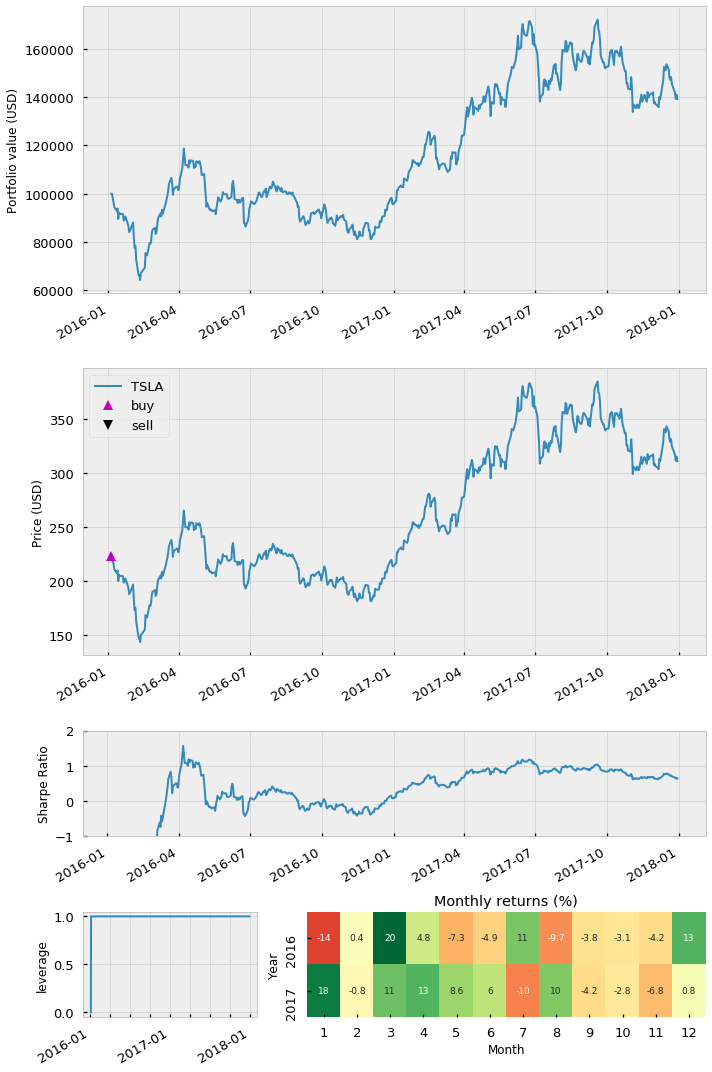

In [5]:
results = run_algorithm(env['test']['start_time'], env['test']['end_time'],
                        initialize=initialize,capital_base=env['capital'],analyze=analyze)

In [6]:
results.to_pickle("results/buyandhold.pickle")